In [123]:
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

pd.set_option("display.max_columns", None)

In [155]:
# Read and process labels file
labels = pd.read_csv("../../data/gz_decals_auto_posteriors_cropped.csv")

labels = labels[[
    "iauname", "smooth-or-featured_smooth_fraction",
    "smooth-or-featured_featured-or-disk_fraction", "smooth-or-featured_artifact_fraction"
]]

labels.columns = ["iauname", "smooth", "featured", "artifact"]

labels["label"] = labels.values[:, 1:].argmax(axis=1)

labels.head()

,iauname,smooth,featured,artifact,label
0,J094651.40-010228.5,0.285737,0.682081,0.032182,1
1,J094630.85-004554.5,0.493212,0.455216,0.051572,0
2,J094631.59-005917.7,0.899878,0.051691,0.048431,0
3,J094744.18-004013.4,0.772967,0.099507,0.127526,0
4,J094751.74-003242.0,0.529303,0.409423,0.061275,0


In [156]:
labels["label"].value_counts()

label
0    58420
1    23904
2      962
Name: count, dtype: int64

In [157]:
all_labels = labels["label"].unique()

IMAGES_PER_LABEL = 400

files_for_each_label = dict()

for label in all_labels:
    files_for_each_label[label] = labels[labels["label"] == label].iloc[:400]["iauname"]

In [161]:
labels = labels[
    labels["iauname"].isin(
        np.hstack([files_for_each_label[label] for label in all_labels])
    )
]
labels.shape

(1200, 5)

In [162]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket_name = "galaxy-morph-manifold-learning-processed"

# paginator = s3.get_paginator('list_objects_v2')
# page_iterator = paginator.paginate(Bucket=bucket_name)

# all_files = []
# for page in page_iterator:
#     if 'Contents' in page:
#         all_files.extend(page['Contents'])

# print(f"Total number of files in the bucket: {len(all_files)}")

In [164]:
images = []

for filename in labels["iauname"].values:
    object_key = f"{filename}.png"

    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    file_stream = BytesIO(response['Body'].read())

    image = Image.open(file_stream)
    image_array = np.array(image)

    images.append(image_array)

images = np.array(images)
images.shape

(1200, 256, 256)

In [ ]:
# images = np.load("../../data/1200_processed_images_balanced.npy")
images.shape

(1200, 256, 256)

In [ ]:
# np.save("../../data/1200_processed_images_balanced.npy", images)

In [167]:
# labels = pd.read_csv("../../data/1k_processed_images.csv")
# labels.head()

In [ ]:
# labels.to_csv("../../data/1200_processed_images_balanced.csv", index=False)

In [179]:
from sklearn.manifold import locally_linear_embedding

embedding, _ = locally_linear_embedding(
    images.reshape(images.shape[0], images.shape[1] * images.shape[2]),
    n_neighbors=40,
    n_components=3,
    random_state=42,
)
embedding.shape

(1200, 3)

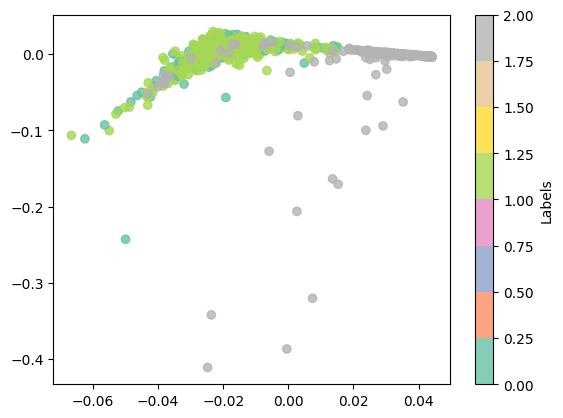

In [180]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels["label"].values, cmap="Set2", alpha=0.8)
plt.colorbar(label="Labels")
plt.show();

In [181]:
fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    color=labels["label"],
    labels={'color': 'Label'},
    title="LLE",
    color_continuous_scale='viridis'
)

fig.update_layout(
    scene=dict(
        xaxis_title=f"LLE Component 1",
        yaxis_title=f"LLE Component 2",
        zaxis_title=f"LLE Component 3"
    )
)

fig.write_html(f"../../plots/LLE_3d_1200_processed_images_balanced.html")

In [182]:
labels["label"].value_counts()

label
1    400
0    400
2    400
Name: count, dtype: int64